<a href="https://colab.research.google.com/github/keglvir/ml_projekt_2025/blob/main/dpt_large_huggingface_flattening_c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DPT-Large Depth Estimation via Hugging Face + Postprocessing for Tiled Diffusion

This notebook uses the `Intel/dpt-large` model from Hugging Face to:
- Estimate relative depth from a single image
- Flatten the background while preserving the foreground
- Provides output for second phase, self-tiling

In [ ]:
# install libraries
!pip install transformers timm opencv-python matplotlib

In [ ]:
# Upload your image
from google.colab import files
from PIL import Image
import io

uploaded = files.upload()
filename = list(uploaded.keys())[0]
image = Image.open(io.BytesIO(uploaded[filename])).convert("RGB")
image = image.resize((384, 384))  # Resize for compatibility
image.save("input.jpg")
image.show()

Saving wood.jpg to wood.jpg


preprocessor_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/942 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


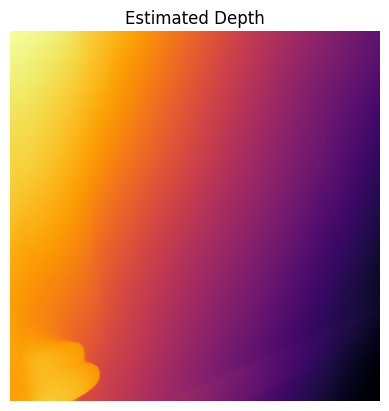

In [ ]:
# Run DPT-Large from Hugging Face to get depth map
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from transformers import DPTImageProcessor, DPTForDepthEstimation

# Load model and processor
processor = DPTImageProcessor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Prepare input
inputs = processor(images=image, return_tensors="pt")
inputs = {k: v.to(model.device) for k, v in inputs.items()}

# Predict
with torch.no_grad():
    outputs = model(**inputs)
    predicted_depth = outputs.predicted_depth

# Resize and normalize
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image.size[::-1],
    mode="bicubic",
    align_corners=False,
).squeeze()

depth = prediction.cpu().numpy()
depth = (depth - depth.min()) / (depth.max() - depth.min())

plt.imshow(depth, cmap='inferno')
plt.title("Estimated Depth")
plt.axis('off')
plt.show()

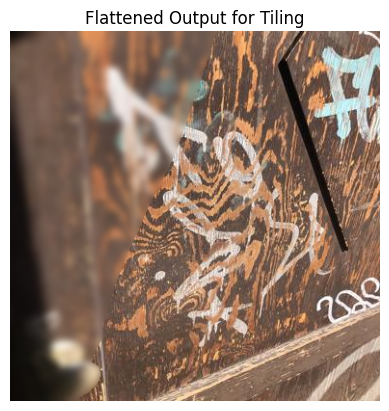

In [ ]:
# Post-process: Blur background, keep foreground
threshold = 0.6
mask = (depth < threshold).astype(np.uint8) * 255

original = cv2.imread("input.jpg")
original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

blurred_bg = cv2.GaussianBlur(original_rgb, (21, 21), 0)
mask_inv = cv2.bitwise_not(mask)

foreground = cv2.bitwise_and(original_rgb, original_rgb, mask=mask)
background = cv2.bitwise_and(blurred_bg, blurred_bg, mask=mask_inv)
flattened = cv2.add(foreground, background)

output_path = "flattened_for_tiling.png"
cv2.imwrite(output_path, cv2.cvtColor(flattened, cv2.COLOR_RGB2BGR))

plt.imshow(flattened)
plt.title("Flattened Output for Tiling")
plt.axis('off')
plt.show()